### Refresher on calculus

In [31]:
import math
import numpy as np
import matplotlib.pyplot as plt

Let's create a quadratic function to apply on an arrat and plot its corresponding parabola

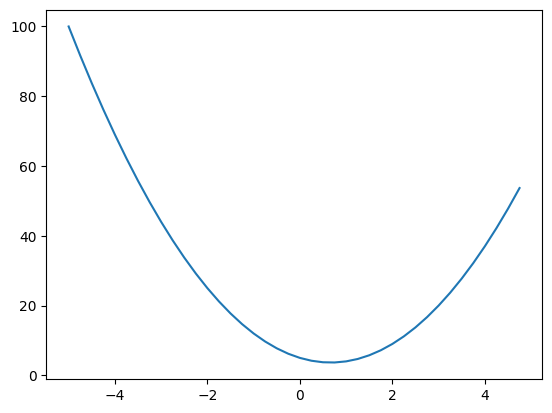

In [32]:
def f(x):
    return 3*x**2 - 4*x + 5

xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

Let's now evaluate the derivative of this function numerically.<br>
The "intensity' of the slope of the derivated function measures the sensitivity with which the function response to a tiny change in its value.

In [33]:
# we set the tiny change h very small
h  = 0.001
# and set a point x at 3.0 where f(x) grows wrt x
x = 3.0
# then compute the derivative at x
(f(x+h) - f(x)) / h

14.00300000000243

The derivative of f(x) at x is the slope of the line that passes through (x,f(x)) and (x+h,f(x+h)).<br>
Read it as the sensitivity of f(x) to x.<br>
Where f(x) increases wrt x, the slope will be positive.

In [34]:
# or at -3.0 where f(x) decreases wrt x
x = -3.0
(f(x+h) - f(x)) / h

-21.996999999998934

While where f(x) decreases wrt x, the slope will be negative.<br>
And where f(x) stabilizes wrt x, the slope will approach 0:

In [35]:
x = 2/3
(f(x+h) - f(x)) / h

0.0029999999995311555

More precisely if we want to measure a function sensitivity wrt to a variable we can:

In [36]:
# set inputs
a = 2.0
b = -3.0
c = 10.0

# create function d
d1 = a*b+c
# bump a by h
a += h
# create function corresponding to a bump by h
d2 = a*b+c

# print the slope
print('d1 =', d1)
print('d2 =', d2)
print('slope =', (d2-d1)/h)

d1 = 4.0
d2 = 3.997
slope = -3.0000000000001137


Slope approx 'b' value as derivating `d = a.b + c` wrt `a` gives `b`.

In [37]:
# if we bump b by h now
a = 2.0
b += h
d2 = a*b+c
# print the slope
print('d1 =', d1)
print('d2 =', d2)
print('slope =', (d2-d1)/h)

d1 = 4.0
d2 = 4.002
slope = 1.9999999999997797


Approxing 'a' value as derivating `d = a.b + c` wrt `b` gives `a`.

### Start to create the main class Value

In [38]:
class Value:

    # takes single value that it wraps and keeps track of
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        # set for optimization in showing the children of the value for operations
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # allows to print the value
    def __repr__(self):
        return f"Value(data={self.data})"

    # allows to add two values together
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        return out

    # allows to multiply two values together
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        return out
    
    # allows to compute tanh of a value
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")
        return out

In [39]:
# instantiate intial values
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
# compute some more
d = a * b + c; d.label = "d"

In [40]:
print('d =', d)
print('d._prev =', d._prev)
print('d._op =', d._op)
print('d.label =', d.label)
print('d.grad = ', d.grad)

d = Value(data=4.0)
d._prev = {Value(data=10.0), Value(data=-6.0)}
d._op = +
d.label = d
d.grad =  0.0


Add vizualisation tool

In [41]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


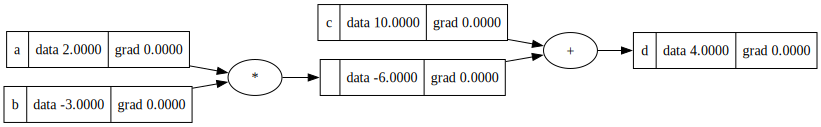

In [42]:
draw_dot(d)

In [43]:
# deepen the graph with new values
e = a * b; e.label = "e"
f = e + c; f.label = "f"
g = Value(-2.0, label="g")
L = f * g; L.label = "L"

In [44]:
print(e.label,'=', e)
print(f.label,'=', f)
print(g.label,'=', g)
print(L.label,'=', L)

e = Value(data=-6.0)
f = Value(data=4.0)
g = Value(data=-2.0)
L = Value(data=-8.0)


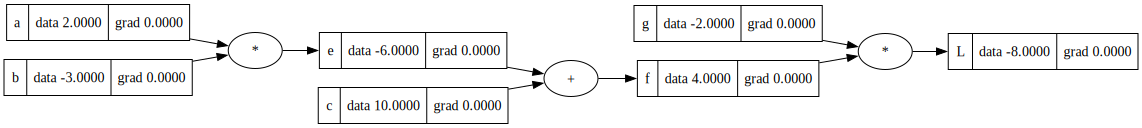

In [45]:
draw_dot(L)

We are vizualising the forward pass of a mathematical expression only composed of additions and multiplications.<br>

#### Manual backpropagation
##### 1/ from scratch
Now we want to run backpropagation by reverting the graph and calculate the gradient at each step.<br>
Read it as `L` being the loss function and some of the other letters eventually being the weights of the nn: we are interested in the derivative of the output wrt some of its 'leaf nodes', those being the weights of the nn.<br>The other leaf nodes will be the data itself which is fixed contrary to the weights that will be iterated on.<br>
So we are going to compute the derivative of `L` wrt to every other letter from `g` back to `a` so we know how the weights are impacting the loss function.<br>

In [46]:
# manually set the derivative of L wrt to itself to 1 (dL/dL = 1)
L.grad = 1.0
# dL/df = g
f.grad = g.data
# dL/dg = f
g.grad = f.data

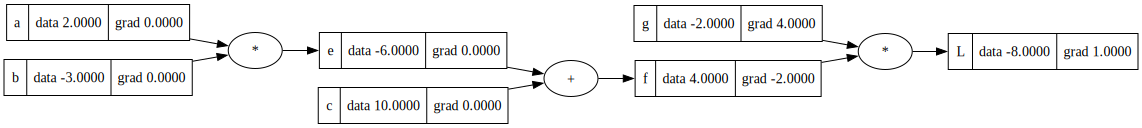

In [47]:
draw_dot(L)

We want to know of `c` impacts `L` through `f`.<br>
Now `f` being an addition, we know that the (local) derivatives of `f` wrt to `c` is `1` and that symetrically wrt to `e` is also `1`.<br>
We apply the chain rule to get the global derivatives of `L` wrt to `c` and `e`.




In [48]:
# chain rule states that dL/dc = dL/df * df/dc = g * 1 = g = -2.0
c.grad = g.data
# and dL/de = dL/df * df/de = g * 1 = g = -2.0
e.grad = g.data

In [49]:
# Additionally, dL/da = dL/de * de/da = g * b = -2.0 * -3.0 = 6.0
a.grad = g.data * b.data
# and dL/db = dL/de * de/db = g * a = -2.0 * 2.0 = -4.0
b.grad = g.data * a.data

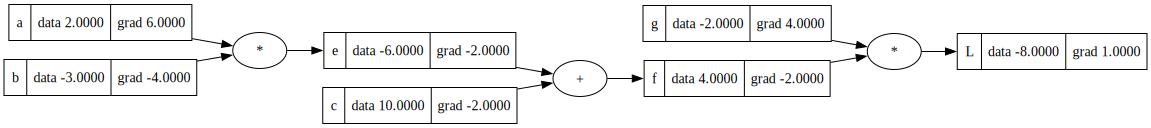

In [50]:
draw_dot(L)

##### 2/ in the context of a neuron

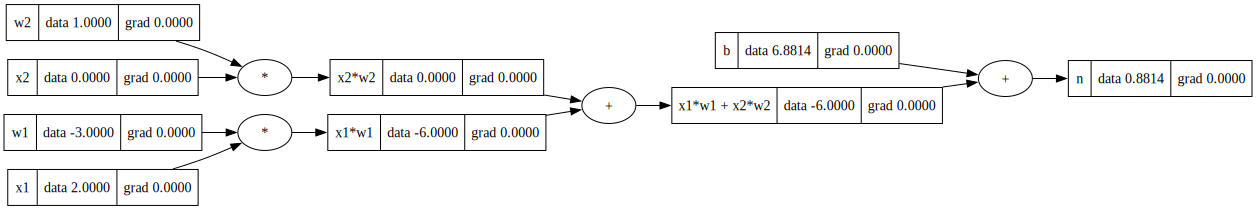

In [51]:
# set inputs x1 and x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# set weights w1 and w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# set bias
b = Value(6.8813735870195432, label="b")
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"

draw_dot(n)

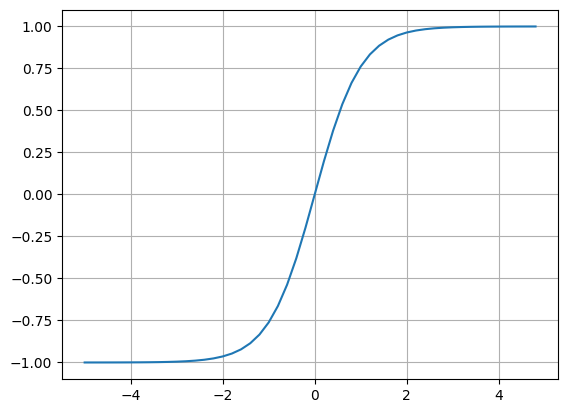

In [52]:
# we chose the output function to be tanh
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

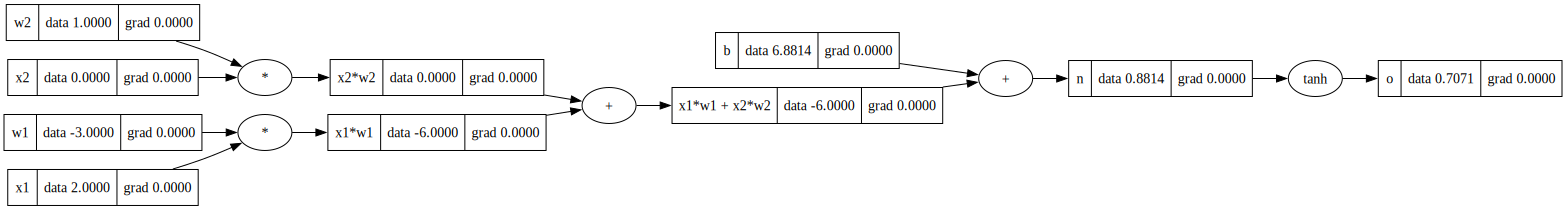

In [53]:
# set the output
o = n.tanh(); o.label = "o"
draw_dot(o)

By notching up the bias `b` we see the output value passed through `tanh` function to converge towards its max value of `1`.<br>
Now start the backpropagation by computing the derivatives at steps by applying the chain rule:

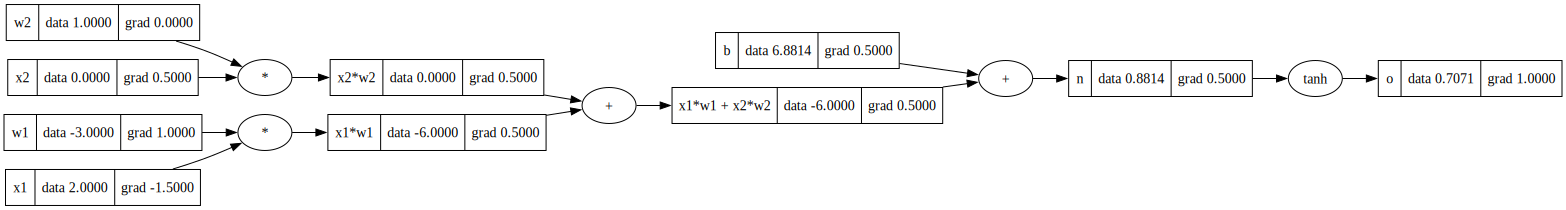

In [54]:
# for addition operators incoming gradients are passed through as:
# do/do = 1
o.grad = 1.0
# do/dn = 1 - tanh(n)^2 = 1 - o^2
n.grad = 1 - o.data**2
# do/db = do/dn * dn/db = (1 - o^2) * 1 = 1 - o^2
b.grad = n.grad
# do/dx1w1x2w2 = do/dn * dn/dx1w1x2w2 = (1 - o^2) * 1 = 1 - o^2
x1w1x2w2.grad = n.grad
# do/dx1w1 = do/dx1w1x2w2 * dx1w1x2w2/dx1w1 = (1 - o^2) * 1 = 1 - o^2
x1w1.grad = x1w1x2w2.grad
# do/dx2w2 = do/dx1w1x2w2 * dx1w1x2w2/dx2w2 = (1 - o^2) * 1 = 1 - o^2
x2w2.grad = x1w1x2w2.grad

# for multiplication operators compute local derivative * incoming gradient
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

draw_dot(o)

#### Now for a more automatic integration of the backpropagation
##### 1/ Compute every backpropagation step automatically
Reimplement de Value class with backpropagation capabilities

In [59]:
class Value:

    # takes single value that it wraps and keeps track of
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        # function to compute chain ruled gradients
        self._backward = lambda: None
        # set for optimization in showing the children of the value for operations
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # prints value.data
    def __repr__(self):
        return f"Value(data={self.data})"

    # adds self + other
    def __add__(self, other):
        # for convenience in adding non Value objects, if other is not a Value object, convert it to one
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        # compute the gradients in the context of an addition operation
        def _backward():
            # we increment ('+=') so we take into account multiple paths to the same value (multivariate chain rule)
            # which is OK as long as we initialize the gradient to 0.0 at the beginning of the backward pass
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    # default addition when unilateral sense is not respected: other + self
    def __radd__(self, other):
        return self + other

    # substracts by negation
    # we first implement a negation function: -self
    def __neg__(self):
        return -1.0 * self
    
    # then we can use the negation function to implement substraction: self - other
    def __sub__(self, other):
        return self + (-other)

    # multiplies self * other
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    # default multiplication when unilateral sense is not respected
    # other * self when self * other cannot be processed
    def __rmul__(self, other):
        return self * other
    
    # computes division as special case of a more general operation
    # we first need a power function: self**other
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f"**{other}")
        
        def _backward():
            self.grad += other * self.data ** (other-1) * out.grad
        out._backward = _backward

        return out

    # then implement the division: self/other
    def __truediv__(self, other):
        return self * other**-1
    
    # computes tanh of a value
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")
                
        def _backward():
            self.grad += (1.0 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    # computes exponentiation
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")

        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        # set a topological sort algorithm
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

Reset values and grads

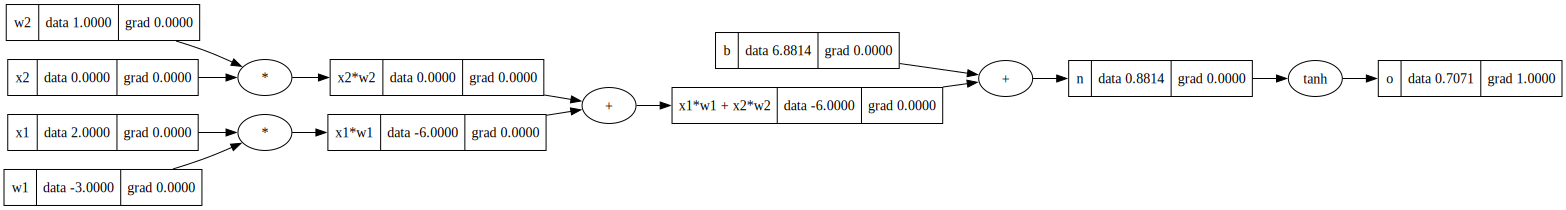

In [56]:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.8813735870195432, label="b")
# values
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
# output
o = n.tanh(); o.label = "o"
# initialize output grad value as the first grad
o.grad = 1.0

draw_dot(o)

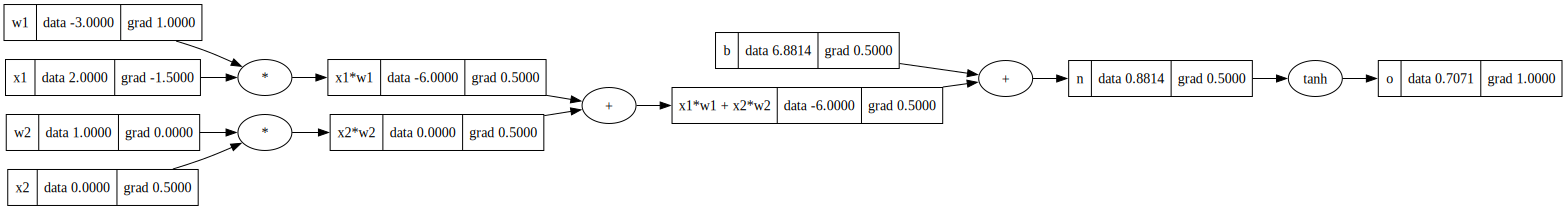

In [28]:
# call the backward functions
# first of the output
o._backward()
# then of the rest
n._backward()
# b does not have a backward
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o)

##### 2/ Automate backpropagation function calls
Before computing backpropagating from a node to its leaf nodes, we need to ensure every preceding steps have been achieved already, that every preceding backpropagations have been processed up to this node.<br>
This 'ordering' of graphs can be achieved through 'topological sort' which is a layout of graphs from left to right.

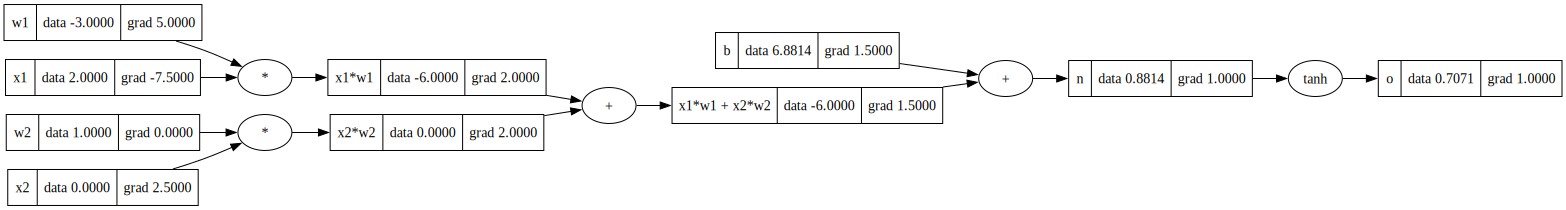

In [29]:
# Set a topological sort algorithm
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

draw_dot(o)

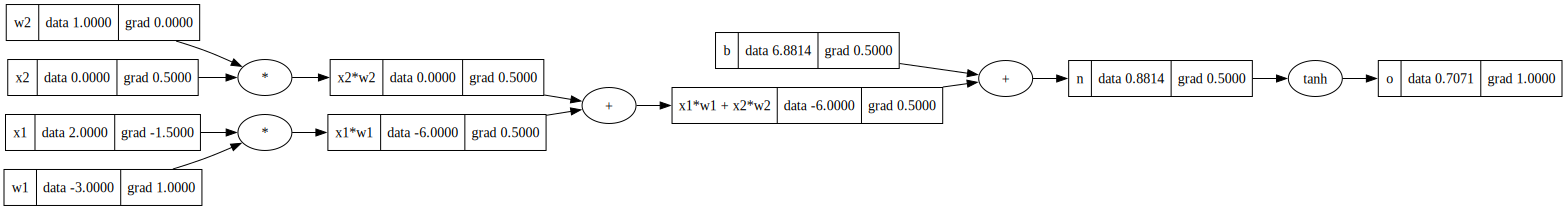

In [57]:
# once topological sort algorithm is integrated in Value class
# just call the new backward function on the output
o.backward()

draw_dot(o)

Additional features to the Value class:
* increment gradients storage instead of storing them once, allowing the workaround the bug of 2 variables with same name in operators;
* conversion of non-Value objects to Value objects to allow unilateral operations: `<object> -> <operator> -> <value>`:<br>
```python
other = other if isinstance(other, Value) else Value(other)
```
* addition of fallback operations if contrary to unilateral sense: `<value> -> <operator> -> <object>`:<br>
```python
def __rmul__(self, other):
    return self * other
```
* exponentiation operation;
* division operation.

Now to test the implementation of these features, we decompose tanh(x) into suboperations:


In [60]:
# we reset the values again
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.8813735870195432, label="b")
# values
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
# original output
o = n.tanh(); o.label = "o"
# but we decompose it as the sum of the exponentiations
e = (2 * n).exp(); e.label = "e"
o = (e - 1) / (e + 1); o.label = "o"
o.backward()

Expected graph should be bigger because of `tanh` replaced by `exp` and `add` but grad values should be conserved:

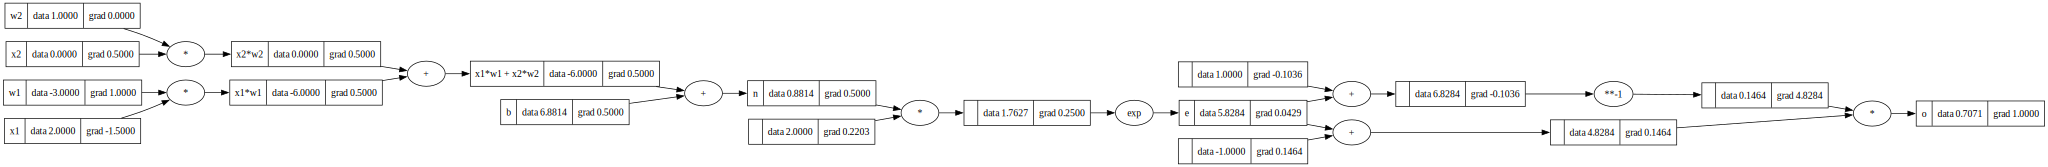

In [61]:
draw_dot(o)